# ЛР №4

## Линейные модели, SVM и деревья решений.

### 1) Импорт библиотек. Загрузка, первичный анализ и масштабирование данных.

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from typing import Dict, Tuple
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

В качестве набора данных мы будем использовать набор данных, [содержащий информацию о прогнозе смертности от сердечной недостаточности](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data)

Датасет состоит из одного файла:
'heart.csv'

In [2]:
data = pd.read_csv('data/heart.csv', sep=",")

In [3]:
# Размер датасета (строки, столбцы)
data.shape

(299, 13)

In [4]:
# Список колонок с типами данных
data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [5]:
# Количество пропущенных значений
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
# Первые 5 строк датасета
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Как видно, приведённый набор данных не имеет пропусков и все колонки имеют численный тип данных. Однако для успешного решения задачи классификации мы должны произвести масштабированние данных в колонках "age", "platelets", "ejection_fraction", "time", "serum_sodium", "serum_creatinine" и "creatinine_phosphokinase".

In [8]:
data['time'] = MinMaxScaler().fit_transform(data[['time']])
data['platelets'] = MinMaxScaler().fit_transform(data[['platelets']])
data['serum_sodium'] = MinMaxScaler().fit_transform(data[['serum_sodium']])
data['creatinine_phosphokinase'] = MinMaxScaler().fit_transform(data[['creatinine_phosphokinase']])
data['age'] = MinMaxScaler().fit_transform(data[['age']])
data['ejection_fraction'] = MinMaxScaler().fit_transform(data[['ejection_fraction']])
data['serum_creatinine'] = MinMaxScaler().fit_transform(data[['serum_creatinine']])

In [9]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0.636364,0,0.071319,0,0.090909,1,0.290823,0.157303,0.485714,1,0,0.000000,1
1,0.272727,0,1.000000,0,0.363636,0,0.288833,0.067416,0.657143,1,0,0.007117,1
2,0.454545,0,0.015693,0,0.090909,0,0.165960,0.089888,0.457143,1,1,0.010676,1
3,0.181818,1,0.011227,0,0.090909,0,0.224148,0.157303,0.685714,1,0,0.010676,1
4,0.454545,1,0.017479,1,0.090909,0,0.365984,0.247191,0.085714,0,0,0.014235,1


Датасет отмасштабирован и готов к решению задачи классификации

### 2) Разделение выборки на обучающую и тестовую.

In [18]:
data_X = data.drop(columns='DEATH_EVENT')
data_Y = data['DEATH_EVENT']
X_train, X_test, Y_train, Y_test = train_test_split(data_X,  data_Y, test_size=0.25, random_state = 0)

In [19]:
Y_train=np.ravel(Y_train)
Y_test=np.ravel(Y_test)

In [33]:
# Проверим правильность разделения выборки на тестовую и обучающую. Посмотрим на размеры матриц.
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(224, 12)
(75, 12)
(224,)
(75,)


In [16]:
print('Входные параметры обучающей выборки:\n\n',X_train.head(), \
      '\n\nВходные параметры тестовой выборки:\n\n', X_test.head(), \
      '\n\nВыходные параметры обучающей выборки:\n\n', Y_train.head(), \
      '\n\nВыходные параметры тестовой выборки:\n\n', Y_test.head())

Входные параметры обучающей выборки:

           age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
258  0.090909        1                  0.005486         1           0.166667   
37   0.763636        1                  0.106150         1           0.545455   
97   0.545455        1                  0.004593         0           0.696970   
191  0.436364        1                  0.004976         0           0.696970   
135  0.636364        0                  0.071319         0           0.393939   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
258                    0   0.252031          0.033708      0.628571    1   
37                     1   0.358710          0.056180      0.914286    0   
97                     0   0.278700          0.067416      0.657143    0   
191                    0   0.344163          0.112360      0.628571    0   
135                    0   0.288833          0.076404      0.685714    1   

     smoking     

### 3) Обучение и тестирование моделей.

#### Модель "Логистическая регрессия"

In [23]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [20]:
cl1 = LogisticRegression().fit(X_train, Y_train)

In [21]:
target1 = cl1.predict(X_test)

In [22]:
print('Процент точности:',accuracy_score(Y_test, target1))

Процент точности: 0.7733333333333333


In [25]:
print('Процент точности для каждого класса:', print_accuracy_score_for_classes(Y_test, target1))

Метка 	 Accuracy
0 	 0.9583333333333334
1 	 0.4444444444444444
Процент точности для каждого класса: None


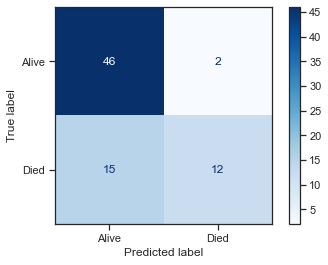

In [26]:
plot_confusion_matrix(cl1, X_test, Y_test, 
                      display_labels=['Alive','Died'], cmap=plt.cm.Blues)

#### Модель "SVM"

In [38]:
svc = SVC()
svc.fit(X_train, Y_train)

SVC()

In [39]:
target2 = svc.predict(X_test)

In [40]:
print('Процент точности:',accuracy_score(Y_test, target2))

Процент точности: 0.7733333333333333


In [43]:
print('Процент точности для каждого класса:', print_accuracy_score_for_classes(Y_test, target2))

Метка 	 Accuracy
0 	 0.9583333333333334
1 	 0.4444444444444444
Процент точности для каждого класса: None


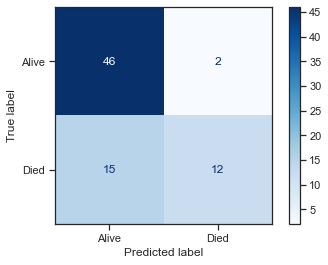

In [44]:
plot_confusion_matrix(svc, X_test, Y_test, 
                      display_labels=['Alive','Died'], cmap=plt.cm.Blues)

#### Модель "Дерево решений"

In [45]:
tree = DecisionTreeClassifier(random_state=0).fit(X_train, Y_train)

In [46]:
target3 = tree.predict(X_test)

In [49]:
print('Процент точности:', accuracy_score(Y_test, target3))

Процент точности: 0.7733333333333333


In [50]:
print('Процент точности для каждого класса:', print_accuracy_score_for_classes(Y_test, target3))

Метка 	 Accuracy
0 	 0.8541666666666666
1 	 0.6296296296296297
Процент точности для каждого класса: None


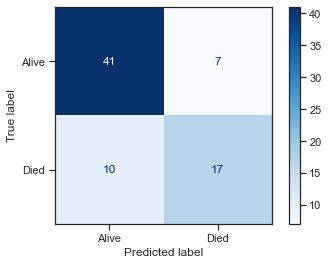

In [52]:
plot_confusion_matrix(tree, X_test, Y_test, 
                      display_labels=['Alive','Died'], cmap=plt.cm.Blues)